# The Best There Ever Was!

### This is a notebook based on Pokemon. Pokemon are fictious creatures people chose to battle with. These people who chose to battle are called trainers. 

## Intro

As a kid, I spent a good bit of my time playing Pokemon. I played Pokemon Gold, in particular. While playing the game I always wonder who was the strongest trainer in the game besides myself. I ran across a YouTube video two months ago. In this YouTube video, the video was about placing trainers, NPCs, from the game to battle against each other. The game did not use trainers from Pokemon Gold, but rather from Pokemon Red. I never got a chance to look at the from this video so I decided to apply it to my project. These were the categories Class, Instance, Win_Count, Lose_Count, Draw_Count, ELO, Kde_Tier, diff_Tier. The original data was in a json file, but I have no experience doing such. I tried a text file, but that did not work. I tried to format it to a CSV file and that worked well too a long time. In addition when formatting this data, I only chose the top trainers who do not have such a great lose record.

## More
I decided to look at ELO, win count, lose count, and class. The YouTuber, pimanrules, describes how he goes about calculating the ELO and the class. I'll briefly describe it here. Every player has an ELO score that goes up when they win and down when they lose. How much the ELO score increases or decrease varies on the difference between the two trainers battling. If you are still confused please check out the references below. The win count or lose count is based off how you how many times you win and lose, respectively. Class was based off a tier list from F- to A+. Pimanrules used a kernel density estimation on the ELO for each trainer to come up with natural boundaries for each of the tiers.

## To Sum Up:

I used this data to do look at outliers, over- and underfitting and high-degree polynomial, and try to produce a BNN of some sort. The BNN was the only section that I could not finish. I also regret not orgainizing the data more so I could better identitfy the trainers' names and such.

List of References: 


[Pokémon Red/Blue AI Tournament - Scientifically Ranking the Pokémon Red Trainers](https://www.youtube.com/watch?v=8yUPhRJtNJM
)

[Elo World REDUX: Scientifically Ranking the Pokémon Red Trainers AGAIN - Level 50 AI Tournament](https://www.youtube.com/watch?v=247qD1qulSQ&t=480s)

[ELO Rating System](https://en.wikipedia.org/wiki/Elo_rating_system)

[Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)

In [34]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
from scipy import optimize
import seaborn as sns; sns.set(); sns.set_context("talk")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [56]:
import csv
with open('pokemon_numbers.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    count = 0 
    Class = []
    Instance = []
    Win_Count = []
    Lose_Count = []
    Draw_Count = []
    ELO = []
    Kde_Tier = []
    Diff_Tier = []
    for row in reader: 
        #print(row['Class'])
        Class.append(row['Class'])
        Instance.append(row['Instance'])
        Win_Count.append(row['Win_Count'])
        Lose_Count.append(row['Lose_Count'])
        Draw_Count.append(row['Draw_Count'])
        ELO.append(row['ELO'])
        Kde_Tier.append(row['Kde_Tier'])
        Diff_Tier.append(row['diff_Tier'])
sig0 = 1.
#print()
# Now change the number string to a number list
Class = list(map(float, Class))
ELO = list(map(float, ELO))
Instance = list(map(float, Instance))
Win_Count = list(map(float, Win_Count))
Lose_Count = list(map(float, Lose_Count))
Draw_Count = list(map(float, Draw_Count))
Kde_Tier = list(map(float, Kde_Tier))
Diff_Tier = list(map(float, Diff_Tier))
Class = pd.to_numeric(Class)
Win_Count = pd.to_numeric(Win_Count)
Lose_Count = pd.to_numeric(Lose_Count)
ELO = pd.to_numeric(ELO)

#Based off previous battling data sets the error for each was about 2. 
#e = sig0*np.ones_like(y)

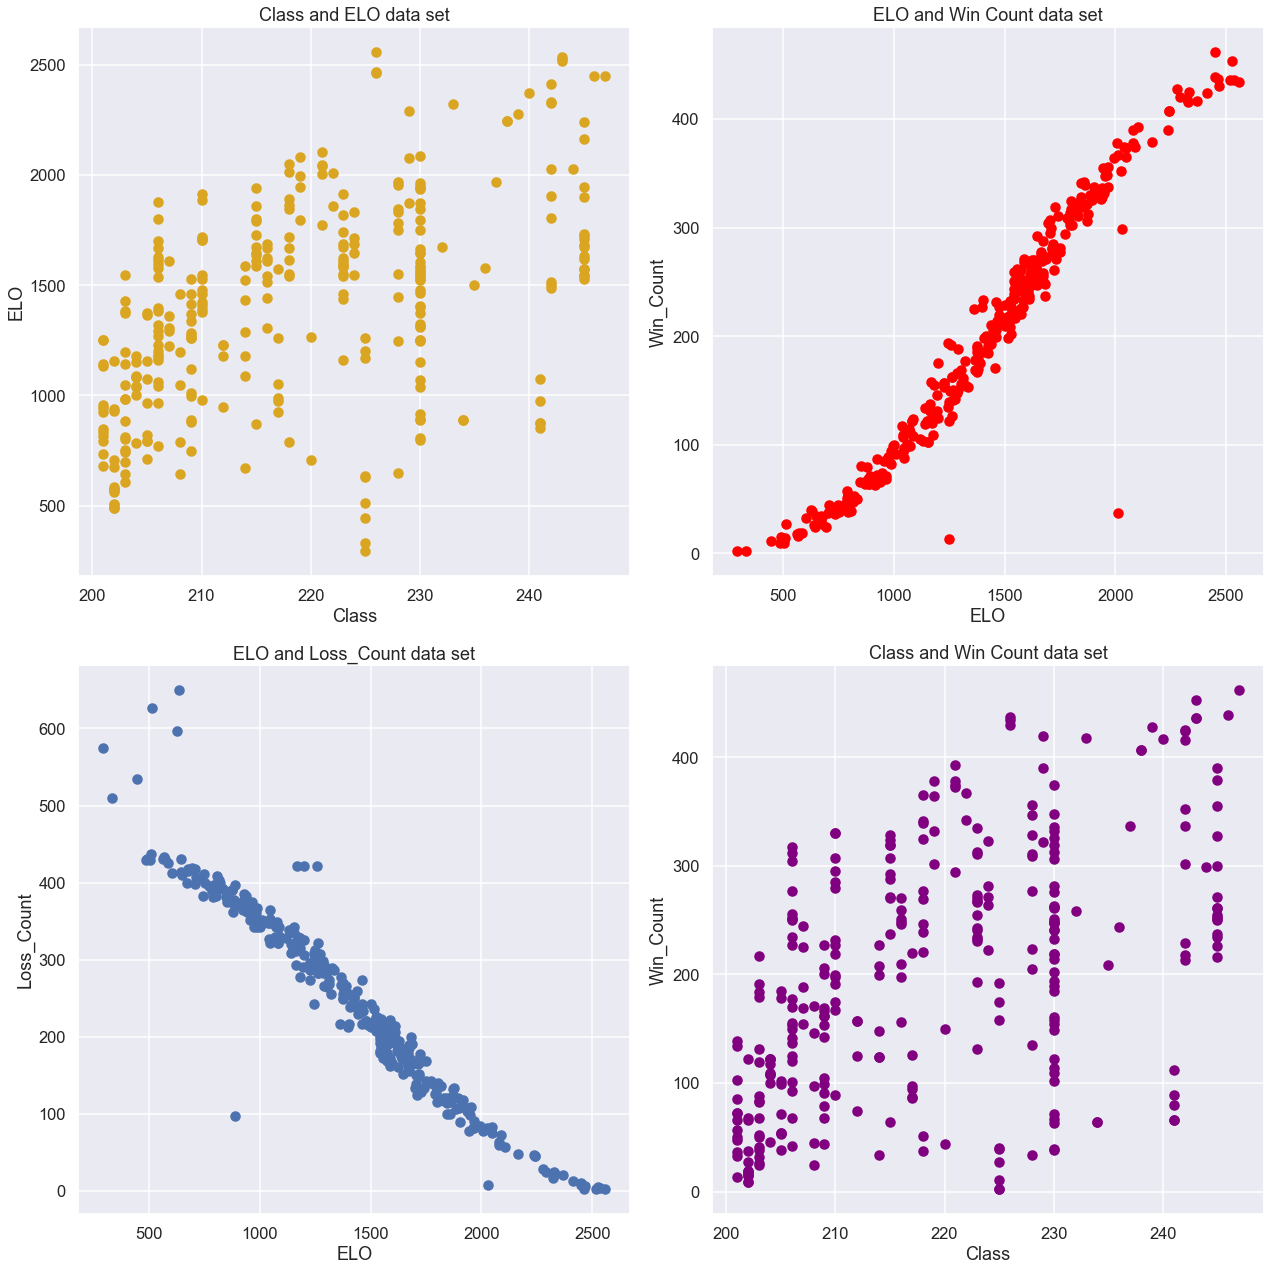

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(18,18))
axs[0, 0].scatter(Class, ELO, color='goldenrod')
axs[0, 0].set(xlabel='Class', ylabel='ELO', title='Class and ELO data set')
axs[0, 1].scatter(ELO, Win_Count, color='red')
axs[0, 1].set(xlabel='ELO', ylabel='Win_Count', title='ELO and Win Count data set')
axs[1, 0].scatter(ELO, Lose_Count)
axs[1, 0].set(xlabel='ELO', ylabel='Loss_Count', title='ELO and Loss_Count data set')
axs[1, 1].scatter(Class, Win_Count, color ='purple')
axs[1, 1].set(xlabel='Class', ylabel='Win_Count', title='Class and Win Count data set')
fig.tight_layout()

## Let's Look, Together, at Outliers

### First, Class and ELO 

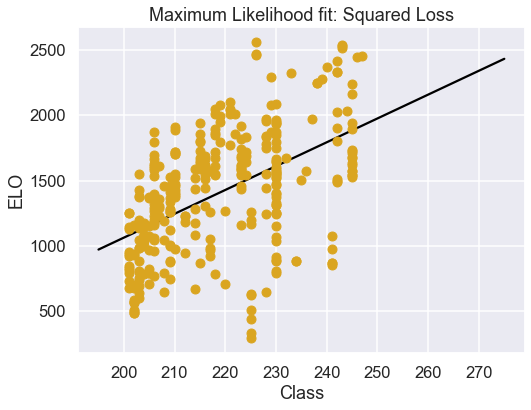

In [58]:
def residuals(theta, Class=Class, ELO=ELO, sigma0=sig0):
    delta_y = ELO - theta[0] - theta[1] * Class
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, Class=Class, ELO=ELO, sigma0=sig0):

    delta_y = ELO - theta[0] - theta[1] * Class
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(195, 275)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(Class, ELO, sig0, fmt='o', color='goldenrod')
ax.plot(xfit, yfit, color='black')
ax.set_xlabel('Class')
ax.set_ylabel("ELO")
ax.set_title('Maximum Likelihood fit: Squared Loss');

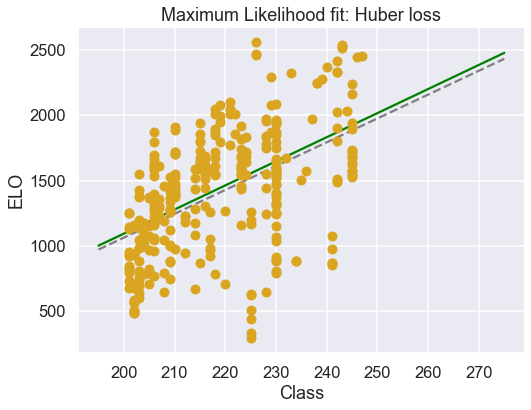

In [59]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, Class=Class, ELO=ELO, sigma0=sig0, c=1):
    return huber_loss((ELO - theta[0] - theta[1] * Class) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(Class, ELO, sig0, fmt='o', color='goldenrod')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='green')
ax.set_xlabel('Class')
ax.set_ylabel("ELO")
ax.set_title('Maximum Likelihood fit: Huber loss');

### Analysis

The observation clearly shows that the data is exerting a an influence on the fit. It seems like there is a positive corrections but there is not organization as to what is or is not a outliers. The huber loss only shows a slightly upward change, which shows that the huber loss is close to our square loss. This was done with a frequentist. I struggled using the data when it came to trying a bayesian framework, and this will remain true for trying to find the outliers for other parameters. But this bayesian framework may have helped with this less clear comparsion. Clearly the squared loss is balance out by the data point above and below our fit line.

## ELO and Lose Count 


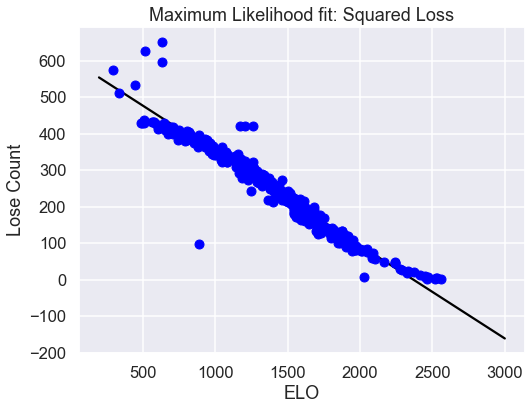

In [60]:
def residuals(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0):
    delta_y = Lose_Count - theta[0] - theta[1] * ELO
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0):
    delta_y = Lose_Count - theta[0] - theta[1] * ELO
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)

# Plot the MLE fit versus the data
xfit = np.linspace(195, 3000)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(ELO, Lose_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_xlabel('ELO')
ax.set_ylabel("Lose Count")
ax.set_title('Maximum Likelihood fit: Squared Loss');

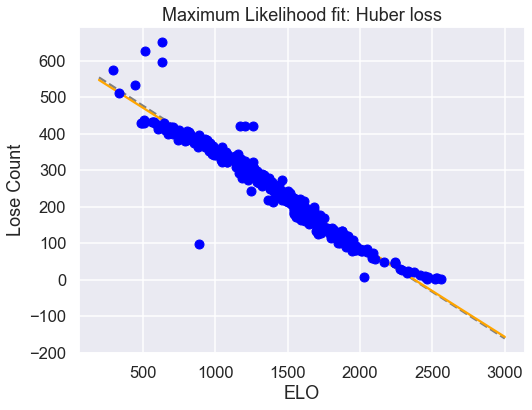

In [61]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0, c=1):
    return huber_loss((Lose_Count - theta[0] - theta[1] * ELO) / sigma0, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(ELO, Lose_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='orange')
ax.set_xlabel('ELO')
ax.set_ylabel("Lose Count")
ax.set_title('Maximum Likelihood fit: Huber loss');

### Analysis

The observation shows that the outliers are not exerting an influence on the fit. The data points show a strong negative corelation. This should be true since the more losts you have means you should have a lower score.There are a few outliers but not many. Most of the points fall directly on the fit line. The huber loss only shows a slightly upward change, which shows that the huber loss is close to our square loss. This was done with a frequentist. This method gave us a good result, so there would be no need for the bayesian framework to be used. Since I had cleared the names while organizing the data it is hard to see what trainer is the outlier

## ELO and Win Count 

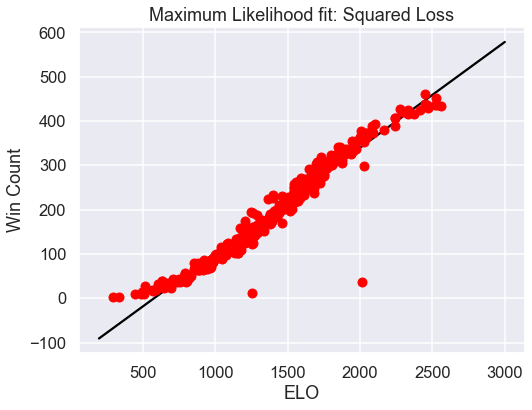

In [62]:
def residuals(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0):
    delta_y = Win_Count - theta[0] - theta[1] * ELO
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0):
    delta_y = Win_Count - theta[0] - theta[1] * ELO
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(195, 3000)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(ELO, Win_Count, sig0, fmt='o', color='red')
ax.plot(xfit, yfit, color='black')
ax.set_xlabel('ELO')
ax.set_ylabel("Win Count")
ax.set_title('Maximum Likelihood fit: Squared Loss');

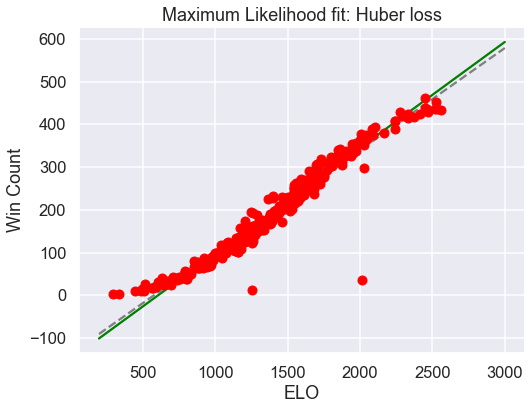

In [63]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0, c=1):
    return huber_loss((Win_Count - theta[0] - theta[1] * ELO) / sigma0, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(ELO, Win_Count, sig0, fmt='o', color='red')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='green')
ax.set_xlabel('ELO')
ax.set_ylabel("Win Count")
ax.set_title('Maximum Likelihood fit: Huber loss');

### Analysis

The observation shows that the outliers are not exerting an influence on the fit. The data points show a strong postive corelation. This should be true since the more wins you have means you should have a higher score. There are a few outliers but not many. Most of the points fall directly on the fit line. The huber loss only shows a slightly downward change, which shows that the huber loss is close to our square loss. This was done with a frequentist. This method gave us a good result, so there would be no need for the bayesian framework to be used. Also, my theory moving forward is that these outliers with high ELO and low win counts and high lose counts had more draws than both wins and losses. Draws do not have an affect on ELO scores. 

## Class and Win Count 

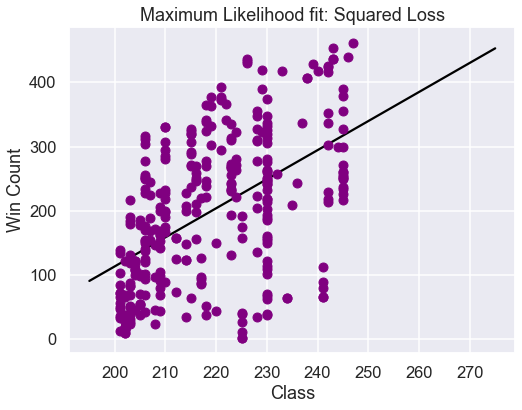

In [64]:
def residuals(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0):
    delta_y = Win_Count - theta[0] - theta[1] * Class
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0):
    delta_y = Win_Count - theta[0] - theta[1] * Class
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(195, 275)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(Class, Win_Count, sig0, fmt='o', color='purple')
ax.plot(xfit, yfit, color='black')
ax.set_xlabel('Class')
ax.set_ylabel("Win Count")
ax.set_title('Maximum Likelihood fit: Squared Loss');

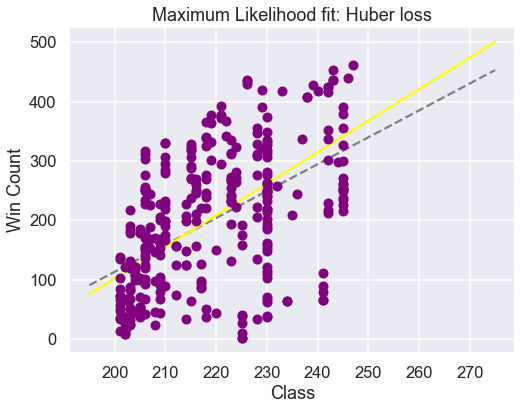

In [65]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0, c=1):
    return huber_loss((Win_Count - theta[0] - theta[1] * Class) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(Class, Win_Count, sig0, fmt='o', color='purple')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='yellow')
ax.set_xlabel('Class')
ax.set_ylabel("Win Count")
ax.set_title('Maximum Likelihood fit: Huber loss');

### Analysis

The observation clearly shows that the data is exerting a an influence on the fit. It seems like there is a positive corrections. The huber loss only shows a slightly upward to the right and lower to the left change, which shows that the huber loss is kinda close to our square loss. But this bayesian framework may have helped with this less clear comparsion. Clearly the squared loss is balance out by the data point above and below our fit line simliar to the comparsion between Class and ELO plot

## Over and underfitting and high-degree polynomial

### Class and ELO

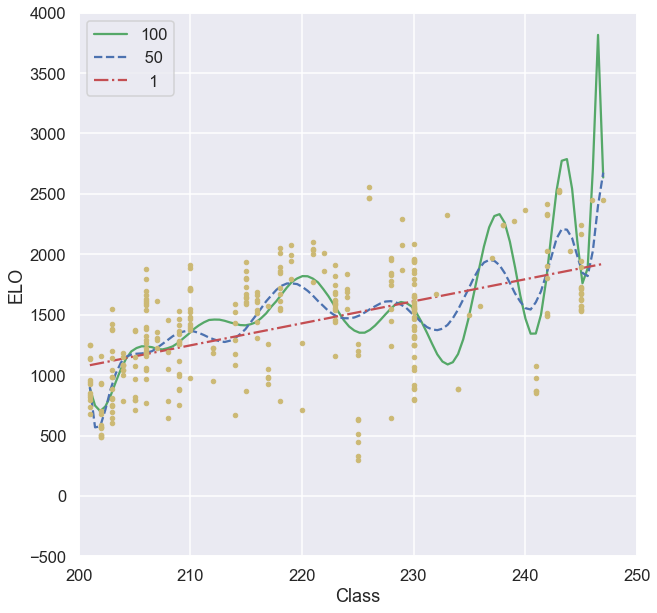

In [71]:
q = max(Class)
w = min(Class)
x_new=np.linspace(w, q, 100).reshape(100, 1)

fig,ax = plt.subplots(1,1,figsize=(10,10))
Class = Class.reshape(-1, 1)
ELO = ELO.reshape(-1, 1)
for style, degree in (("g-", 100), ("b--", 50), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(Class, ELO)
    y_newbig = polynomial_regression.predict(x_new)
    ax.plot(x_new, y_newbig, style, label=f'{degree:>3}')
ax.plot(Class, ELO, "y.")
ax.legend(loc="best")
ax.set_xlabel("Class")
ax.set_ylim([-500,4000])
ax.set_xlim([200,250])
ax.set_ylabel("ELO");

### Analysis

The order of one does not plot fit the data at all as expected. After experimenting, anything beyond 100 orders would be just over fitting, and my laptop could not take going to such high levels. There is an explosion towards the higher class on the plot, which could be compensating for the lack of data for higher Class compared to the amount of points for the low Class. This is similar to my last plot. None of these polynomials seem like a perfect fit. Even the higher order polynomials struggle with the variety of points in the beginning. It does seems like however the highest order is trying to copy the peaks and dips in the data. 

## ELO and Lose Count 
Overfitting is occurring at 90 order and 25. So I lowered it

order  25
order  15
order   1


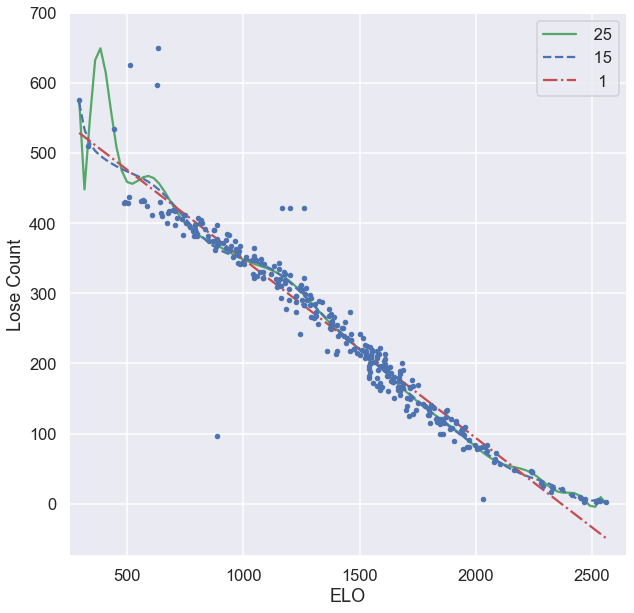

In [29]:
q = max(ELO)
w = min(ELO)
x_new=np.linspace(w, q, 100).reshape(100, 1)

fig,ax = plt.subplots(1,1,figsize=(10,10))
Lose_Count = Lose_Count.reshape(-1, 1)
ELO = ELO.reshape(-1, 1)
for style, degree in (("g-", 25), ("b--", 15), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(ELO, Lose_Count)
    y_newbig = polynomial_regression.predict(x_new)
    ax.plot(x_new, y_newbig, style, label=f'{degree:>3}')
    print(f'order {degree:>3}')
ax.plot(ELO, Lose_Count, "b.")
ax.legend(loc="best")
ax.set_xlabel("ELO")
ax.set_ylim([-75,700])
ax.set_xlim([250,2650])
ax.set_ylabel("Lose Count");

### Analysis

Since there is a strong correlation, it does not take a high order to fit the data. This is also clear based on the principal that the order of 1 fits the data pretty well. The outliers in the beginning of the plot that have high lost counts and a low ELO effect the 25 order. The 25 order tries to fit the outliers. Even when I went for a high order of 100, the model fails to capture the outliers and occurs in an error. 

## ELO and Win Count 
ELO was too big for the x values so we shift the analysis to place WIn count as the x value. 

order  90
order  25
order   1


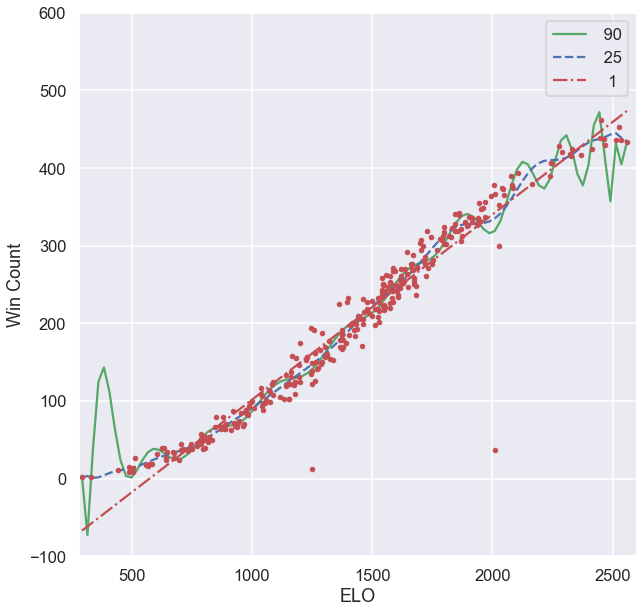

In [30]:
q = max(ELO)
w = min(ELO)
x_new=np.linspace(w, q, 100).reshape(100, 1)

fig,ax = plt.subplots(1,1,figsize=(10,10))
Win_Count = Win_Count.reshape(-1, 1)
ELO = ELO.reshape(-1, 1)
for style, degree in (("g-", 90), ("b--", 25), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(ELO, Win_Count)
    y_newbig = polynomial_regression.predict(x_new)
    ax.plot(x_new, y_newbig, style, label=f'{degree:>3}')
    print(f'order {degree:>3}')
ax.plot(ELO, Win_Count, "r.")
ax.legend(loc="best")
ax.set_xlabel('ELO')
ax.set_ylim([-100,600])
ax.set_xlim([280,2600])
ax.set_ylabel("Win Count");

### Analysis

I am shocked that the two distance outliers do not effect any of the orders. I do not understand the slight bump in the beginning of the higher order of 90 for this dataset. Yet, this high degree polynomial balances in class there were explosion towards the ends, so maybe that what that is. Again, due to the high positive correlation, the order of one would work.  

## Class and Win Count 

order  75
order  50
order   1


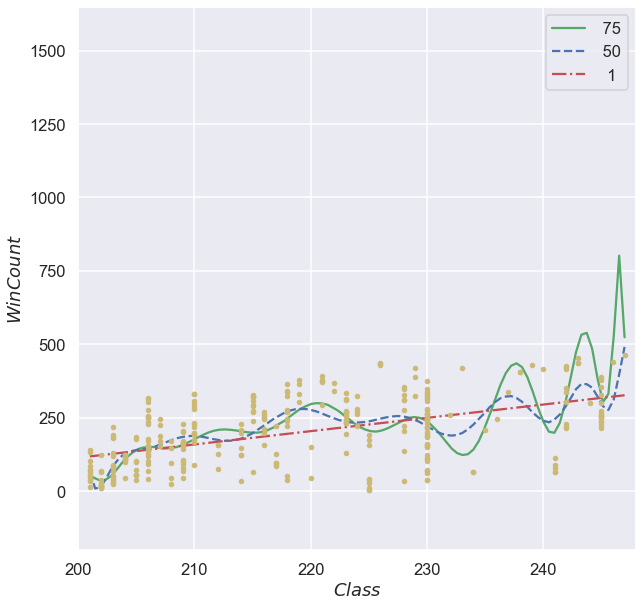

In [74]:
q = max(Class)
w = min(Class)
x_new=np.linspace(w, q, 100).reshape(100, 1)

fig,ax = plt.subplots(1,1,figsize=(10,10))
Win_Count = Win_Count.reshape(-1, 1)
Class = Class.reshape(-1, 1)
for style, degree in (("g-", 75), ("b--", 50), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(Class, Win_Count)
    y_newbig = polynomial_regression.predict(x_new)
    ax.plot(x_new, y_newbig, style, label=f'{degree:>3}')
    print(f'order {degree:>3}')
ax.plot(Class, Win_Count, "y.")
ax.legend(loc="best")
ax.set_xlabel("$Class$")
ax.set_ylim([-202,1650])
ax.set_xlim([200,248])
ax.set_ylabel("$Win Count$");

### Analysis

The order of one does not plot fit the data at all. After experimenting, anything beyond 75 orders would be just over fitting. There is an explosion towards the higher class on the plot, which could be compensating for the lack of data for higher Class compared to the amount of points for the low Class. None of these polynomials seem like a perfect fit. Even the higher order polynomials struggle with the variety of points in the beginning. 

## Beginning of BNN

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_context("talk")

from warnings import filterwarnings
filterwarnings('ignore')

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles
# Import theano and pymc3

# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # Is this is really necessary?
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
#print(floatX)

Class = scale(Class)
Class = Class.reshape(-2, 2)
ELO = ELO.reshape(-2,2)
#res = Class[0 : 100]
#res2 = ELO[0 : 100]

print(len(Class))
print(len(ELO))
Class = Class.astype(floatX)
ELO = ELO.astype(floatX)

# Split into training and test data. test_size is proportion in test data.
X_train, X_test, Y_train, Y_test = train_test_split(Class, ELO, test_size=.5, 
                                                    random_state=0)
#del Class[58:]
#del ELO[58:]
#print(res)
#print(res2)
#print(X_train)
#print(X_test)
#print(Y_train) 
#print(Y_test)
#print(res[res2==0, 0])

158
158


In [77]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5   # this is the number of neurons, not hidden layers

    # Initialize random weights between each layer
    init_1 = np.random.randn(Class.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data 
        # container pm.Data.  It's still the same thing, but we can later 
        # change the values of the shared variable (to switch in the test-data 
        # later) and pymc3 will just use the new data. Like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to 1st hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(Class.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from 2nd hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh( pm.math.dot(ann_input, weights_in_1) )
        act_2 = pm.math.tanh( pm.math.dot(act_1, weights_1_2) )
        act_out = pm.math.sigmoid( pm.math.dot(act_2, weights_2_out) )

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[1] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

AttributeError: module 'pymc3' has no attribute 'floatX'

In [ ]:
print(Y_train.shape[1])

In [ ]:
print(Class.shape[0])